# Adaptive Filtering with pLMS

The purpose of this notebook is to implement the algorithm presented in the paper "The p-norm generalization of the LMS algorithm for adaptive filtering" by Kivinen et al (2006), and test to it out for various values of p on some simple data sets. 

We have chosen to use the MNIST and Fashion MNIST datasets, restricting ourselves to binary classification between the classes with labels 0 and 1. We also use Logistic Regression (forgetting the on-line setting of the problem) on these datasets as a baseline benchmark for accuracy and as a reliability check (as a correctly implemented pLMS algorithm should, when setting p=2, result in a very similar learned weight vector and accuracy as Logistic Regression). 

The results below show that the pLMS algorithm as we have implemented it is indeed very similar to Logistic Regression when p=2, and that higher values of p do not improve the accuracy. As the authors mention in their paper, they expect that higher values of p can lead to better results when the weight vector we are trying to learn is quite sparse (few non-zero entries). For the MNIST/Fashion MNIST datasets we would expect the proportion of non-zero weights to be at least 0.3 and 0.6 respectively.

Therefore, we may have better luck showing the merits of pLMS with large p if we found a data set for which both 1) the baseline accuracy set by Logistic Regression/2-LMS is not so high (it was 99.85% and 98.3% for our data sets) and 2) the true weight vector is considerably more sparse than what we have here.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Import MNIST data

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [3]:
# Should be 70,000 images (28 by 28 for dimensionality of 784)  
print("Image Data Shape" , mnist.data.shape)
print("Label Data Shape", mnist.target.shape)

Image Data Shape (70000, 784)
Label Data Shape (70000,)


In [4]:
# We will focus on binary classification of images with label 0 or 1
mnist_relevant_indices = np.where(mnist.target <= 1.0)[0]

In [5]:
data = mnist.data[mnist_relevant_indices]
target = mnist.target[mnist_relevant_indices]

In [6]:
from sklearn.model_selection import train_test_split
mnist_train_data, mnist_test_data, mnist_train_label, mnist_test_label = train_test_split(
    data, target, test_size=1/7.0, random_state=0)

# Import Fashion MNIST data

In [7]:
import fashion_mnist_reader
# This requires the data from https://github.com/zalandoresearch/fashion-mnist has been downloaded into data/fashion
X_train, y_train = fashion_mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = fashion_mnist_reader.load_mnist('data/fashion', kind='t10k')

In [8]:
#Filter for labels 0 and 1
fmnist_train_data = X_train[np.where(y_train <= 1.0)[0]]
fmnist_train_label = y_train[np.where(y_train <= 1.0)[0]]
fmnist_test_data = X_test[np.where(y_test <= 1.0)[0]]
fmnist_test_label = y_test[np.where(y_test <= 1.0)[0]]

# Preview Images

In [9]:
def print_images(n, images, labels):
    plt.figure(figsize=(20,4))
    for index, (image, label) in enumerate(zip(images[0:n], labels[0:n])):
        plt.subplot(1, n, index + 1)
        plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
        plt.title('Label: %i\n' % label, fontsize = 15)

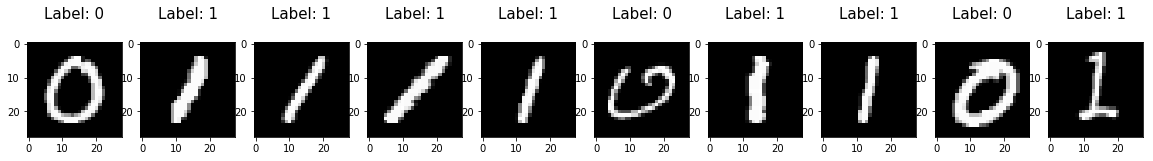

In [10]:
print_images(10, mnist_train_data, mnist_train_label)

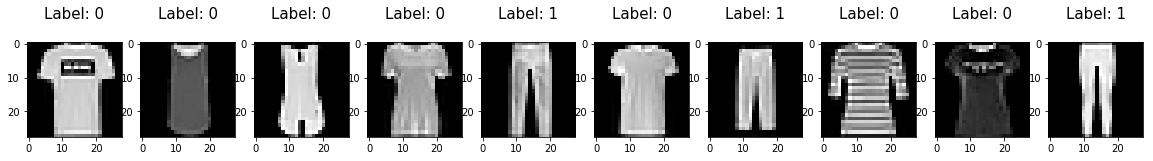

In [11]:
print_images(10, fmnist_train_data, fmnist_train_label)

# Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
def LogitR(X_train, y_train, X_test, y_test):
    LR_model = LogisticRegression(solver = 'lbfgs')
    LR_model.fit(X_train, y_train)
    predictions = LR_model.predict(X_test)
    accuracy = LR_model.score(X_test, y_test)
    weights = np.concatenate([LR_model.intercept_, LR_model.coef_[0]])
    return weights, predictions, accuracy

In [14]:
mnist_weights, mnist_test_predictions, mnist_test_accuracy = LogitR(mnist_train_data, mnist_train_label, \
                   mnist_test_data, mnist_test_label)

In [15]:
mnist_test_accuracy

0.99857954545454541

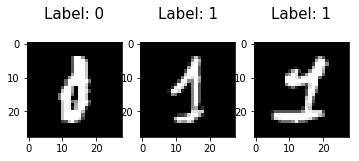

In [16]:
mnist_misclassified_ix = np.where(mnist_test_predictions != mnist_test_label)
print_images(10, mnist_test_data[mnist_misclassified_ix], mnist_test_label[mnist_misclassified_ix])

In [17]:
fmnist_weights, fmnist_test_predictions, fmnist_test_accuracy = LogitR(fmnist_train_data, fmnist_train_label, \
                   fmnist_test_data, fmnist_test_label)

In [18]:
fmnist_test_accuracy

0.98250000000000004

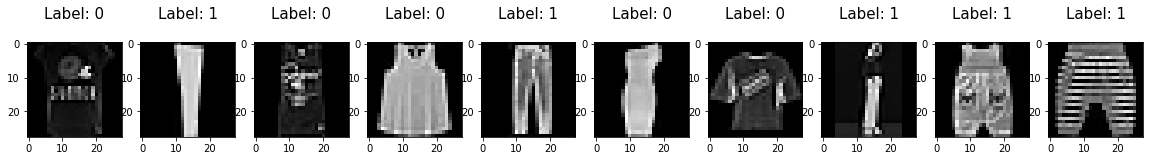

In [19]:
fmnist_misclassified_ix = np.where(fmnist_test_predictions != fmnist_test_label)
print_images(10, fmnist_test_data[fmnist_misclassified_ix], fmnist_test_label[fmnist_misclassified_ix])

# pLMS

In this section we imitate the online learning scenario presented in "The p-norm generalization of the LMS algorithm for adaptive filtering" by Kivinen et al 2006. We imagine that our online learner has been presented with the training samples one by one, and then must make a prediction for one element from the test set. The accuracy is the average over all elements of the test set.

In [20]:
from scipy.special import expit as h # Logistic Sigmoid as transfer function h
def f(w, p):
    if p == 2: return w
    return np.power(np.linalg.norm(w, p), 2-p) * np.multiply(np.sign(w), np.power(np.abs(w), p-1))

In [21]:
def pLMS(p, X_train, y_train, X_test, y_test):
    q = p/(p-1)
    
    # We add a column of 1s to the X data to allow a bias parameter
    X_train_b = np.concatenate([np.ones((X_train.shape[0],1)), X_train], axis = 1)
    X_test_b = np.concatenate([np.ones((X_test.shape[0],1)), X_test], axis = 1)
    
    n_train_samples, x_dim = X_train_b.shape
    w = np.zeros(x_dim)
    
    # X_p is defined as the max p-norm of any x. Here we approximate it with
    # the max p-norm of any x already observed.
    
    # This learning rate ensures the regret is bounded by
    # 0.25*(p-1)*X_p^2*|u|_q^2 (Theorem 7 Kivinen et al, pLMS)
    #rate = 4/((p-1)*X_p**2)
    X_p = 0
    
    for t in range(n_train_samples):
        x = X_train_b[t]
        X_p = max(X_p, np.linalg.norm(x, ord = p))
        rate = 4/((p-1)*X_p**2)
        y_prediction = h(np.dot(w, x))
        y_label = y_train[t]
        w = f(f(w,q) - rate*(y_prediction-y_label)*x, p)
        
    predictions = np.around(h(np.matmul(X_test_b, w)))
    accuracy = np.mean(y_test.T == predictions)
    
    return w, accuracy
    
    

In [22]:
mnist_pLMS_weights, mnist_pLMS_accuracy = pLMS(2, mnist_train_data, mnist_train_label, \
        mnist_test_data, mnist_test_label)
mnist_pLMS_accuracy

0.99857954545454541

In [23]:
fmnist_pLMS_weights, fmnist_pLMS_accuracy = pLMS(2, fmnist_train_data, fmnist_train_label, \
        fmnist_test_data, fmnist_test_label)
fmnist_pLMS_accuracy

0.98350000000000004

# Comparison of learned weights between Logistic Regression and 2LMS

In [24]:
mnist_weight_delta = mnist_pLMS_weights - mnist_weights
np.linalg.norm(mnist_weight_delta)/len(mnist_weight_delta)**.5 # Root Mean Square Error

0.0038228464283098953

In [25]:
fmnist_weight_delta = fmnist_pLMS_weights - fmnist_weights
np.linalg.norm(fmnist_weight_delta)/len(fmnist_weight_delta)**.5 # Root Mean Square Error

0.05747116805470117

# Accuracy of pLMS for various p

In [26]:
def plot_pLMS_accuracy_vs_p(X_train, y_train, X_test, y_test):
    p_axis = np.logspace(np.log10(2),np.log10(40),20)
    accuracy = []
    for p in p_axis:
        accuracy.append(pLMS(p, X_train, y_train, X_test, y_test)[1])
        
    fig_accuracy = plt.figure(figsize=(30,9))
    ax = fig_accuracy.add_subplot(122)
    ax.plot(p_axis, accuracy,'bo', label = 'Accuracy')
    ax.set_title('Accuracy vs p')
    ax.legend(loc='best')
    ax.grid()
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('p')

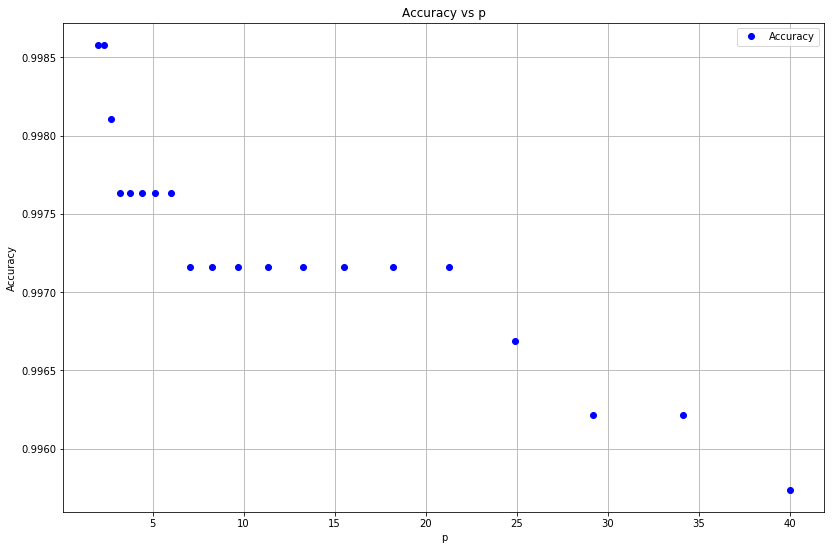

In [27]:
plot_pLMS_accuracy_vs_p(mnist_train_data, mnist_train_label, \
        mnist_test_data, mnist_test_label)

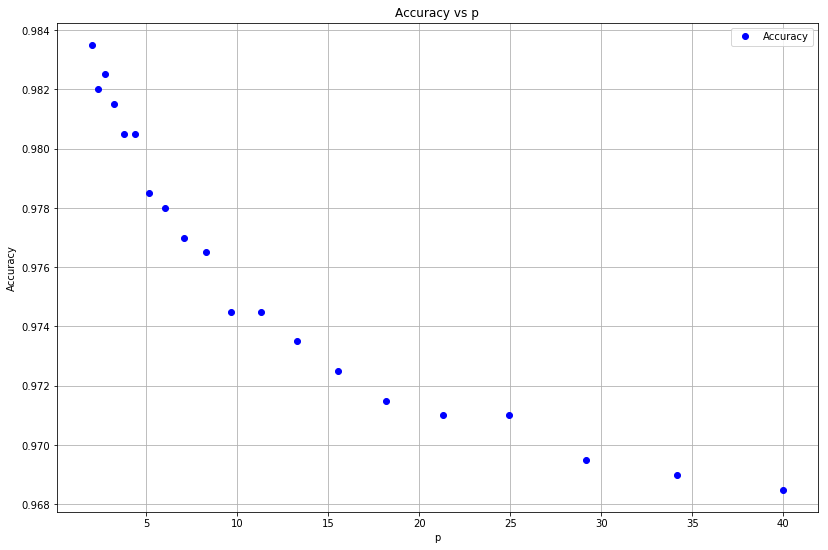

In [28]:
plot_pLMS_accuracy_vs_p(fmnist_train_data, fmnist_train_label, \
        fmnist_test_data, fmnist_test_label)